# Replicate QST article sims

### 1. Red sideband Hamiltonian

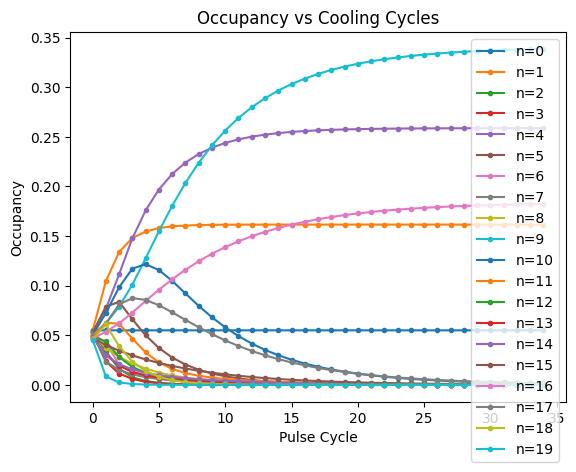

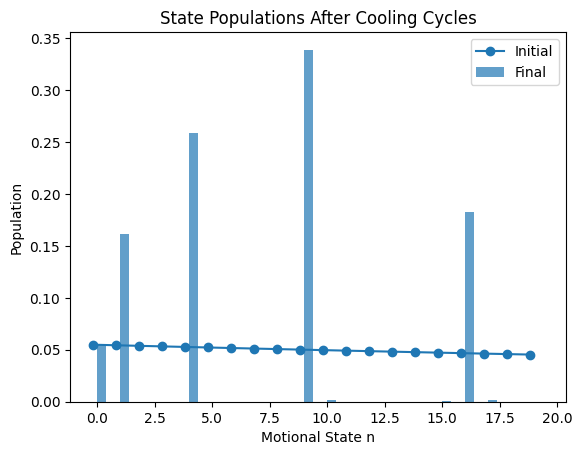

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.0001  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 0.005  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))

# Hamiltonian (Red Sideband for Pulse)
H_pulse = 1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)
# Hamiltonian (Free evolution for Dissipation) - Assuming H0 during dissipation phase? 
# For now, let's assume H_diss = 0 for the dissipative step relative to the rotating frame.
H_diss = gamma * s_z_full 

# --- Collapse Operators for Dissipation ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / sum(W)
G = gamma / 2 
tg = 2 / G  # Dissipation duration adjusted for rates

c_ops = []
for i, c in enumerate(cosal):
    op = tensor(s_minus, (1j * c * eta * xop).expm())
    c_ops.append(np.sqrt(2 * G * W[i]) * op)

# --- Construct Liouvillians ---
# 1. Pulse Step: Coherent RSB drive, NO dissipation (or minimal?)
# Typically only Unitary part active during pulse
L_pulse = liouvillian(H_pulse, []) 

# 2. Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
# H = 0 (or H0), c_ops active
L_diss = liouvillian(H_diss, c_ops)

# --- Propagators ---
# Propagator for Pulse step (duration tau)
prop_pulse = (L_pulse * tau).expm()

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cycle (Pulse -> Dissipation)
prop_cycle = prop_diss * prop_pulse 


# --- Simulation ---
num_pulses = 34 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr() 
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()

### 2 Complete Hamiltonian

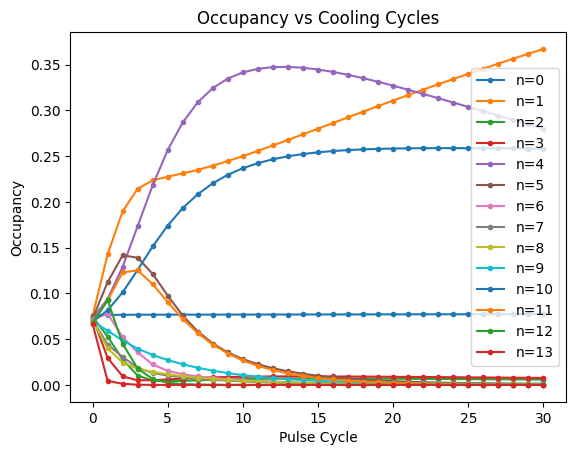

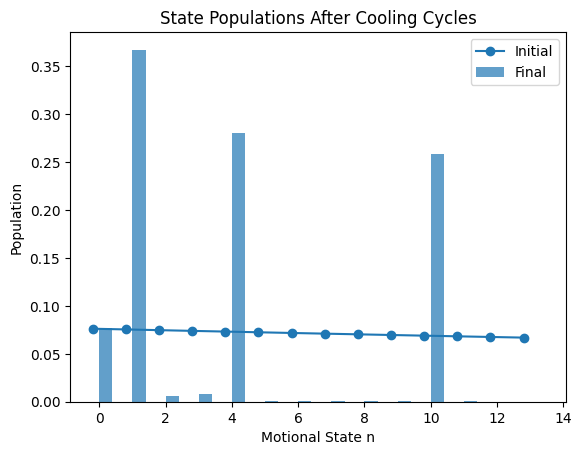

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1  # Detuning
nu = 1.0     # Motional frequency
omega_list = [0.001, 0.005, 0.01]
Omega=.02  # Rabi frequency
eta = 0.1    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 1000 * nu  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
# tg = 200 # Dissipation duration (time gap)

# Define operators
N = 14  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()
sy = sigmay()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_x_full = tensor(sigmax(), qeye(N))
s_y_full = tensor(sy, qeye(N))

# Displacement operator
alpha = 1j * eta
D_alpha = tensor(qeye(2), displace(N, alpha))

H_original = Delta*s_z_full/2 + nu*a_dag_full*a_full + Omega/2*(s_plus_full * D_alpha + s_minus_full * D_alpha.dag()) 

# --- Collapse Operators for Dissipation ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / sum(W)
G = gamma / 2 
tg = 2 / G  # Dissipation duration adjusted for rates

c_ops = []
for i, c in enumerate(cosal):
    op = tensor(s_minus, (1j * c * eta * xop).expm())
    c_ops.append(np.sqrt(2 * G * W[i]) * op)


# Hamiltonian (Free evolution for Dissipation)
# H_diss = G * s_z_full 
H_diss = Delta*s_z_full/2 + nu*a_dag_full*a_full

# --- Construct Liouvillians ---

# Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
L_diss = liouvillian(H_diss, c_ops)

# Normal Step: Coherent RSB drive, NO dissipation
L_normal = liouvillian(H_original, [])

# --- Propagators ---

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Propagator for Pulse step (duration tau)
prop_pulse = (L_normal * tau).expm()

# Combined Propagator for one cycle (Pulse Sequence -> Dissipation)
prop_cycle =  prop_diss * prop_pulse

# --- Simulation ---
num_pulses = 30 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr() 
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()

In [ ]:
# Simulation of sideband cooling and trapped states

import numpy as np
import matplotlib.pyplot as plt
import time as time
from scipy.linalg import expm
import scipy.optimize

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

D=1
nu=1
eta=.02
Omega=.01
G=1000
ni=2
b=-np.log(ni/(ni+1))

print(f"Initial population {ni}")


nmax = 20
n0 = 1
tau = 2*np.pi/(Omega*eta*np.sqrt(n0))
tg = 2/G
dt = tau + tg
tsteps = 20

# operators
sz = np.array([[1,0j],[0j,-1]])
sx = np.array([[0j,1],[1,0j]])
sy = np.array([[0j,1j],[-1j,0j]])
Id = np.array([[1,0j],[-0j,1]])
Idn = np.eye(nmax)
sm = np.array([[0,0],[1,0j]])
a = np.diag(np.sqrt(np.arange(1,nmax)),1)
ad = np.transpose(a)
xop=a+ad
pop=a-ad
n = np.dot(ad,a)

#Liouvillian

#all order Hamiltonian
print(expm(1j*eta*xop))

Initial population 2
[[ 9.99800020e-01+0.00000000e+00j  0.00000000e+00+1.99960004e-02j
  -2.82786150e-04+0.00000000e+00j  0.00000000e+00-3.26533319e-06j
   3.26533319e-08+0.00000000e+00j  0.00000000e+00+2.92060279e-10j
  -2.38466220e-12-0.00000000e+00j  0.00000000e+00-1.80263518e-14j
   1.27465556e-16+0.00000000e+00j  0.00000000e+00+8.49769704e-19j
  -5.37436872e-21-0.00000000e+00j  0.00000000e+00-3.25355067e-23j
   1.95963623e-25+0.00000000e+00j  0.00000000e+00+1.37290066e-27j
  -1.46646911e-29-0.00000000e+00j  0.00000000e+00-2.28041204e-31j
   3.85842195e-33+0.00000000e+00j  0.00000000e+00+6.17973232e-35j
  -9.11490835e-37-0.00000000e+00j  0.00000000e+00-1.24224588e-38j]
 [ 0.00000000e+00+1.99960004e-02j  9.99400100e-01+0.00000000e+00j
   0.00000000e+00+2.82729592e-02j -4.89734672e-04+0.00000000e+00j
   0.00000000e+00-6.53001332e-06j  7.30092287e-08+0.00000000e+00j
   0.00000000e+00+7.15350966e-10j -6.30886260e-12+0.00000000e+00j
   0.00000000e+00-5.09836731e-14j  3.82379673e-16+0.00